## Yandex geocoding API

This notebook works with [Yandex Geocoding API](https://tech.yandex.ru/maps/geocoder/doc/desc/concepts/about-docpage/), you have to get an API key to replicate the process.

Free limit for HTTP GET request is now only 1000 addresses per day. 

[Open data about housing](https://www.reformagkh.ru/opendata?gid=2353101&cids=house_management&page=1&pageSize=10) is used for the example. 

In [59]:
import pandas as pd
import requests

import geopandas as gpd
from pyproj import CRS
from shapely import wkt

import matplotlib.pyplot as plt
import contextily as ctx

import warnings
warnings.filterwarnings("ignore")

In [60]:
# reading api keys
api_keys = pd.read_excel('../api_keys.xlsx')
api_keys.set_index('key_name', inplace=True)

# API Yandex organization search
geocoding_api_key = api_keys.loc['yandex_geocoding']['key']

In [61]:
# importing housing data
tab = pd.read_csv('./input_data/opendata_reform_tatarstan.csv', sep = ';')

# selecting a city with a number of houses within our geocoder limit
df_sample = tab[tab['formalname_city']=='Верхний Услон']
len(df_sample)

39

In [62]:
URL = 'https://geocode-maps.yandex.ru/1.x'

# retrieving the coordinates in wkt format

def geocode(address):
    params = { 
        "geocode" : address, 
        "apikey": geocoding_api_key,
        "format": "json"
        }
    response = requests.get(URL, params=params)
    response_json = response.json()
    try:
        point = response_json['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']        
        wkt_point = 'POINT ({})'.format(point)
        
        return wkt_point
    
    except Exception as e:
        print("for address", address)
        print("result is", response_json)
        print("which raises", e)
        return ""

In [63]:
# applying geocoding
df_sample['coordinates'] = df_sample['address'].apply(geocode)

In [64]:
# shapely wkt submodule to parse wkt format

def wkt_loads(x):
    try:
        return wkt.loads(x)
    except Exception:
        return None
    
df_sample['coords_wkt'] = df_sample['coordinates'].apply(wkt_loads)
df_sample = df_sample.dropna(subset=['coords_wkt'])

print ('Number of geocoded houses - ', len(df_sample))

Number of geocoded houses -  39


In [65]:
# transform to geodataframe
housing_sample = gpd.GeoDataFrame(df_sample, geometry='coords_wkt')
housing_sample = housing_sample.set_crs(epsg=4326)

In [66]:
# write the result to Shapefile
housing_sample.to_file('./output/housing_test.shp')

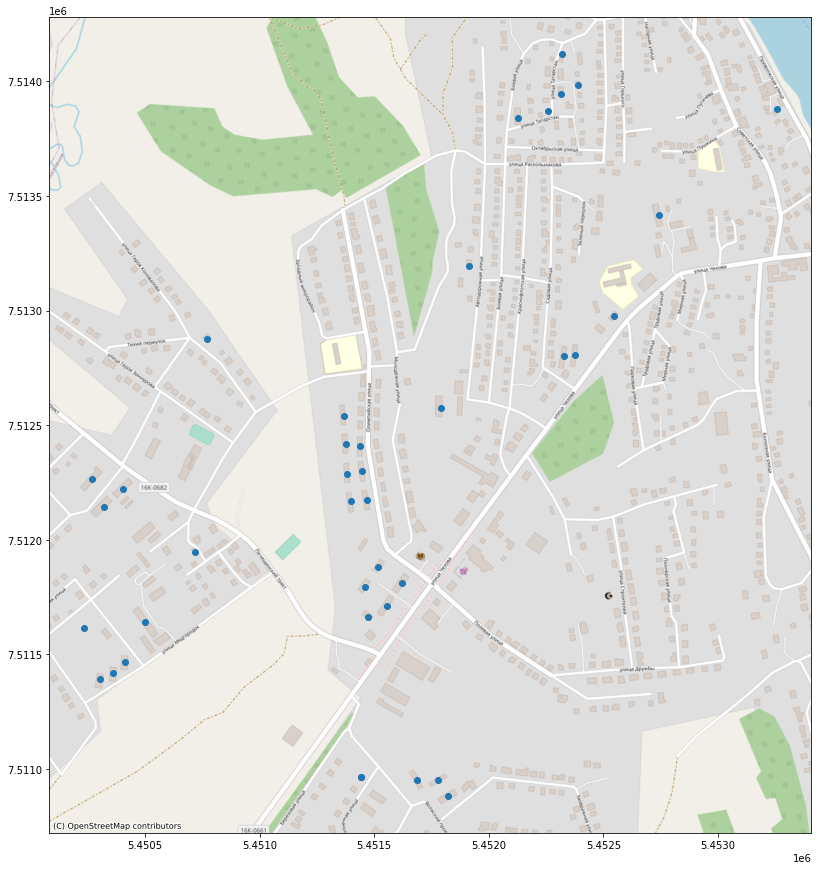

In [67]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(15,15))

# Plot the data
housing_sample.to_crs(epsg=3857).plot(ax=ax)

# Add basemap with basic OpenStreetMap visualization
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)